# Attempt to fine-tune ByT5!

In [19]:
import sys
from google.colab import drive
drive.mount('/content/drive')
#drive_path = 'drive/My Drive/projekt/'
drive_path = 'drive/My Drive/Colab Notebooks/Deep learning/projekt/'

sys.path.append(drive_path) 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
import pandas as pd
df = pd.read_pickle(drive_path+'clean_data_train.pkl')

df.head()

,wer,cer,reference_text,transcription,book_name,test_wer,ref_words,num_words
159241,0.444444,0.000000,jeg forstod det alt sammen elkablerne forlænge...,jeg forstod det alt sammen el kablerne forlæng...,Mellem verden og mig,0.363636,"[jeg, forstod, det, alt, sammen, elkablerne, f...",9
133774,0.166667,0.034483,de er en underlig fisk miklos,de er en underlig fisk i miklos,Feber ved daggry,0.142857,"[de, er, en, underlig, fisk, miklos]",6
174748,0.052632,0.009009,man fandt søfolkene klyngende sig til deres dø...,man fandt søfolkene klyngede sig til deres død...,Hjertets hemmeligheder,0.052632,"[man, fandt, søfolkene, klyngende, sig, til, d...",19
161336,0.000000,0.000000,hjemme i sverige opdagede familien myrdal at d...,hjemme i sverige opdagede familien myrdal at d...,amerika_under_huden,0.000000,"[hjemme, i, sverige, opdagede, familien, myrda...",32
52057,0.183673,0.006154,men ud fra den antiinstrumentalistiske tænknin...,men ud fra den anti instrumentalist i ske tænk...,Ståsteder,0.166667,"[men, ud, fra, den, antiinstrumentalistiske, t...",49


In [4]:
X = df['transcription'].tolist() 
y = df['reference_text'].tolist()

(array([6.3432e+04, 6.0806e+04, 3.6745e+04, 1.7871e+04, 8.1310e+03,
        3.9460e+03, 1.8520e+03, 9.4200e+02, 4.6800e+02, 2.4100e+02,
        1.4800e+02, 8.4000e+01, 5.4000e+01, 3.5000e+01, 2.4000e+01,
        2.2000e+01, 1.0000e+01, 8.0000e+00, 1.1000e+01, 7.0000e+00,
        2.0000e+00, 3.0000e+00, 6.0000e+00, 2.0000e+00, 6.0000e+00,
        4.0000e+00, 4.0000e+00, 0.0000e+00, 3.0000e+00, 2.0000e+00,
        2.0000e+00, 1.0000e+00, 6.0000e+00, 2.0000e+00, 0.0000e+00,
        3.0000e+00, 1.0000e+00, 5.0000e+00, 1.0000e+00, 2.0000e+00]),
 array([   3. ,   43.4,   83.8,  124.2,  164.6,  205. ,  245.4,  285.8,
         326.2,  366.6,  407. ,  447.4,  487.8,  528.2,  568.6,  609. ,
         649.4,  689.8,  730.2,  770.6,  811. ,  851.4,  891.8,  932.2,
         972.6, 1013. , 1053.4, 1093.8, 1134.2, 1174.6, 1215. , 1255.4,
        1295.8, 1336.2, 1376.6, 1417. , 1457.4, 1497.8, 1538.2, 1578.6,
        1619. ]),
 <a list of 40 Patch objects>)

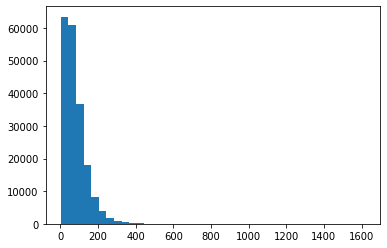

In [5]:
import matplotlib.pyplot as plt

plt.hist([len(x) for x in X],bins = 40)

In [6]:
len(max(X , key = len))

1619

In [7]:
X[0]

'jeg forstod det alt sammen el kablerne forlænger ledningerne hele ritualet'

In [8]:
y[0]

'jeg forstod det alt sammen elkablerne forlængerledningerne hele ritualet'

In [9]:
#!git clone https://github.com/ufal/multilexnorm2021
#%cd multilexnorm2021

!pip3 install torchmetrics==0.4.1
!pip3 install transformers==4.8.2
!pip3 install pytorch_lightning==1.3.8

     |████████████████████████████████| 234 kB 12.4 MB/s 
     |████████████████████████████████| 2.5 MB 12.4 MB/s 
     |████████████████████████████████| 3.3 MB 46.2 MB/s 
     |████████████████████████████████| 895 kB 19.8 MB/s 
     |████████████████████████████████| 813 kB 12.2 MB/s 
     |████████████████████████████████| 132 kB 51.9 MB/s 
     |████████████████████████████████| 829 kB 44.0 MB/s 
     |████████████████████████████████| 636 kB 43.2 MB/s 
     |████████████████████████████████| 1.1 MB 44.1 MB/s 
     |████████████████████████████████| 192 kB 48.6 MB/s 
     |████████████████████████████████| 271 kB 52.3 MB/s 
     |████████████████████████████████| 160 kB 47.3 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=37002328645060b37e66ac65d1e0c14181400dd293c8d2455afe52431fb4b0ca
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninst

In [10]:
from transformers import T5ForConditionalGeneration, AutoTokenizer

model = T5ForConditionalGeneration.from_pretrained('google/byt5-small')
tokenizer = AutoTokenizer.from_pretrained('google/byt5-small')

Downloading:   0%|          | 0.00/698 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.20G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.59k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.50k [00:00<?, ?B/s]

In [11]:
train_inputs = tokenizer(X, return_tensors="pt", padding=True, truncation=True, max_length=256)

train_tgt = tokenizer(y, return_tensors="pt", padding=True, truncation=True, max_length=256)

train_inputs['labels'] = train_tgt['input_ids']

In [12]:
import torch

class TextDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, y_encodings=None):
        self.encodings = encodings

    def __getitem__(self, idx):
        item= {key: val[idx] for key, val in self.encodings.items()}
        #item['labels'] = {key: torch.tensor(val[idx]) for key, val in self.y_encodings.items()}
        return item

    def __len__(self):
        return len(self.encodings['labels'])

train_dataset = TextDataset(train_inputs)

In [13]:
!git config --global user.email "jens.perregaard.thorsen@gmail.com"
!git config --global user.name "jenspt"
!sudo apt-get install git-lfs
!git lfs install
#find auth_token by logging in to huggingface with
!huggingface-cli login
#create repo
#!huggingface-cli repo create byt5_ft_error_only

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  git-lfs
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 2,129 kB of archives.
After this operation, 7,662 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 git-lfs amd64 2.3.4-1 [2,129 kB]
Fetched 2,129 kB in 0s (20.0 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package git-lfs.
(Reading database ... 155222 files and directories cu

In [14]:
!huggingface-cli repo create byt5_ft_all_clean_data_lr_1e3

git version 2.17.1
Error: unknown flag: --version

Sorry, no usage text found for "git-lfs"

You are about to create jenspt/byt5_ft_all_clean_data_lr_1e3
Proceed? [Y/n] y

Your repo now lives at:
  https://huggingface.co/jenspt/byt5_ft_all_clean_data_lr_1e3

You can clone it locally with the command below, and commit/push as usual.

  git clone https://huggingface.co/jenspt/byt5_ft_all_clean_data_lr_1e3



In [22]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=1,              # total number of training epochs
    per_device_train_batch_size=4,  # batch size per device during training
    #per_device_eval_batch_size=2,   # batch size for evaluation
    warmup_steps=3000,                # number of warmup steps for learning rate scheduler (used to be 500)
    weight_decay=0.01,               # strength of weight decay
    learning_rate=1e-3,           # default = 5e-5=0.5e-4
    logging_dir='./logs',            # directory for storing logs
    logging_steps=50,
    #eval_steps = 100,
    overwrite_output_dir = True,
    save_strategy = 'epoch',
    #logging_strategy = 'epoch',
)

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    #eval_dataset=test_dataset            # evaluation dataset
)

trainer.train()


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 194892
  Num Epochs = 1
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 48723


Step,Training Loss
50,53.211000
100,47.304400
150,34.716500
200,16.783700


KeyboardInterrupt: ignored

In [ ]:
model.push_to_hub("jenspt/byt5_ft_all_clean_data_lr_1e3", use_auth_token= 'xLBCMTdwnVYcIXUMjmmLNkHwXYGZDlVmhQNcCOMgmTNPkswRbiDGcfuhhVGAdbDxyHiMxpATszDjiPslvNQXJQuMLpfWTXupWkEvDvKRkGwnCRKPfGbcJGuvOzmKKLwP')